# Figure 2
Assumes all data is in ../../data

## Setup and load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression


from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_violinplot_w_percent,
    colors_for_sequence,
)

In [3]:
DATA_PATH = "../../data/"

In [4]:
def plot_motif_boxplot_stripplot(df: pd.DataFrame, ax=None) -> plt.Axes:
    """
    Plots a boxplot and stripplot for motif data.

    Args:
        df (pd.DataFrame): The input DataFrame containing the motif data.
        ax (Optional[plt.Axes]): The matplotlib Axes object to plot on. If not provided, a new figure and Axes will be created.

    Returns:
        plt.Axes: The matplotlib Axes object containing the plot.

    Raises:
        None

    Example:
        df = pd.DataFrame(...)
        ax = plot_motif_boxplot_stripplot(df)
        plt.show()
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sequence = df.iloc[0]["m_sequence"]
    pos = list(range(len(sequence)))
    colors = colors_for_sequence(sequence)
    custom_palette = {}
    for p, c in zip(pos, colors):
        custom_palette[str(p)] = c
    labels = []
    for n, s in zip(df.iloc[0]["m_sequence"], df.iloc[0]["m_structure"]):
        labels.append(f"{n}\n{s}")
    sns.boxplot(
        x="r_loc_pos",
        y="r_data",
        data=df,
        linecolor="black",
        order=pos,
        palette=custom_palette,
        showfliers=False,
        ax=ax,
    )
    sns.stripplot(
        x="r_loc_pos", y="r_data", data=df, order=pos, color="black", size=2, ax=ax
    )
    ax.set_xticks(ticks=range(len(pos)), labels=labels)
    return ax

In [5]:
def format_small_plot(ax):
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    plt.subplots_adjust(left=0.3, bottom=0.21, top=0.98)

In [6]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## plots

### Figure 2A: reactivity overlap between non-wc and wc

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_63005/661083160.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['WC', 'NON-WC']);


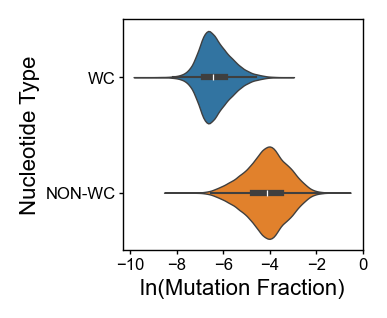

In [7]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = sns.violinplot(
    x="ln_r_data",
    y="r_type",
    data=df,
    hue="r_type",
    order=["WC", "NON-WC"],
    ax=ax,
    linewidth=0.5,
)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("Nucleotide Type", labelpad=2)
ax.set_yticklabels(["WC", "NON-WC"])
ax.set_xticks([-10, -8, -6, -4, -2, 0])
format_small_plot(ax)
plt.savefig("pngs/figure_2a.png", dpi=600)

### Figure 2B: reactivity cummulative distribution

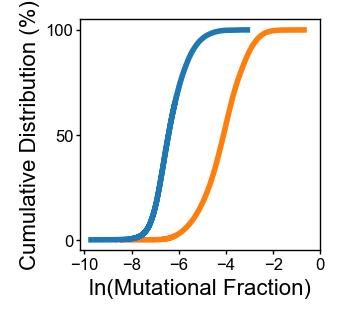

In [8]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df.sort_values("r_type", inplace=True, ascending=True)
colors = {"WC": "tab:blue", "NON-WC": "tab:orange"}
# Loop through each unique r_type to plot the cumulative distribution
for r_type, group_data in df.groupby("r_type"):
    sorted_data = np.sort(group_data["ln_r_data"])
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
    ax.plot(sorted_data, cdf, label=r_type, lw=2, color=colors[r_type])
ax.set_ylabel("Cumulative Distribution (%)", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4, -2, 0])
format_small_plot(ax)
plt.savefig("pngs/figure_2b.png", dpi=600)

### Figure 2C

In [9]:
df["ln_r_data"].replace(-np.inf, -10, inplace=True)
df["ln_r_data"].describe()

count    237528.000000
mean         -5.090406
std           1.367130
min         -10.000000
25%          -6.319969
50%          -5.057727
75%          -3.966479
max          -0.691768
Name: ln_r_data, dtype: float64

In [10]:
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df["r_type_binary"] = df["r_type"].apply(lambda x: 1 if x == "WC" else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df[["ln_r_data"]], df["r_type_binary"])
# Compute probabilities for the original data
df["prob_WC"] = model.predict_proba(df[["ln_r_data"]])[:, 1]
# Display the probabilities
df.sort_values("prob_WC", ascending=False)[["ln_r_data", "r_type", "prob_WC"]]
# df.to_csv("Prob.csv", index=False)

,ln_r_data,r_type,prob_WC
113731,-10.000000,WC,0.999998
89327,-10.000000,WC,0.999998
53872,-10.000000,WC,0.999998
6584,-10.000000,WC,0.999998
85296,-10.000000,WC,0.999998
...,...,...,...
234212,-1.013022,NON-WC,0.000003
234179,-0.994414,NON-WC,0.000003
55879,-0.972755,NON-WC,0.000003
55890,-0.853363,NON-WC,0.000002


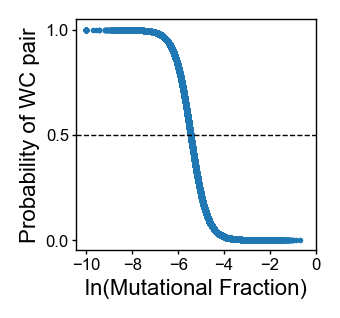

In [11]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax.scatter(df["ln_r_data"], df["prob_WC"], s=1)
ax.set_ylabel("Probability of WC pair", labelpad=2)
ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4, -2, 0])
plt.axhline(y=0.5, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)
plt.savefig("pngs/figure_2c.png", dpi=600)

### Figure 2XXX: not used will be in next figure? 

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_63005/2683826172.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_63005/2683826172.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Text(-0.15, 0.5, 'Mutation Fraction')

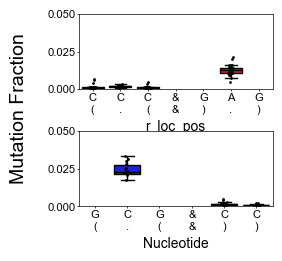

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2.5))
plt.subplots_adjust(
    hspace=0.55
)  # Increase hspace to add more vertical space between plots
axs = ax.flatten()
df_sub = df.query('m_sequence == "CCC&GAG"')
plot_motif_boxplot_stripplot(df_sub, ax=ax[0])
df_sub = df.query('m_sequence == "GCG&CC"')
plot_motif_boxplot_stripplot(df_sub, ax=ax[1])
axs[1].set_xlabel("Nucleotide")
for ax in axs:
    ax.set_ylabel("")
    ax.set_ylim(0, 0.05)
    publication_style_ax(ax)
fig.text(
    -0.15,
    0.5,
    "Mutation Fraction",
    va="center",
    rotation="vertical",
    fontsize=14,
    name="Arial",
)